# Detecting Alcohol Intoxication Using Cell Phone Accelerometer Data
> Aswin Rajkumar

## Introduction
The aim of this experiment is to **predict whether the user is intoxicated or not using a 10-second long accelerometer data stream**. A person is considered intoxicated if the Transdermal Alcohol Concentration (TAC) level is above `0.8`. Cell phone acccelerometer data used for this analysis was collected from 13 participants by [Killian, J.A., Passino, K.M., Nandi, A., Madden, D.R. and Clapp, J., Learning to Detect Heavy Drinking Episodes Using Smartphone Accelerometer Data. In Proceedings of the 4th International Workshop on Knowledge Discovery in Healthcare Data co-located with the 28th International Joint Conference on Artificial Intelligence (IJCAI 2019) (pp. 35-42)](http://ceur-ws.org/Vol-2429/paper6.pdf).

For having a fresh perspective on analyzing the dataset, I only used the information in the resource for understanding the data and skipped the analysis section. This is also a time-blocked exercise that I completed within 2 days. Hence, I mention multiple ideas in the future work section to expand on this initial analysis.

## Abstract
In this exercise I consider multiple factors including:
- Strategies to join time series datasets of unequal resolution - timestamp unit conversion, generating missing timestamps, aligning datasets by exact matching and fuzzy matching of timestamps and through interpolation.
- Using interpolation to find missing data.
- Analyzing and extracting temporal, frequency and spectral features from the signals
- Segmentation and resampling of the signals
- Picking non-linear classifiers for the task
- Creating custom transformers and a scikit-learn pipeline for data transformation and feature extraction
- Parallelization for improving the performance of the classifiers
- Grid Search for hyperparameter tuning and manual tuning of parameters. For exmaple, increasing maximum iterations to help the model converge.
- Reducing overfitting by cross validation, using a hold out set and by mixing resampled signals to signals with 400 samples to increase the size of the dataset.

The performance of the final model is as follows
```
Cross validation F1 scores: [0.83306031 0.82328565 0.83571902 0.8187543  0.83191972]
Average cross validation F1: 0.8285477974485742
Cross validation time: 111.68637895584106 seconds
Time taken to train on full training set: 18.890563011169434 seconds

              precision    recall  f1-score   support

       Sober       0.91      0.85      0.88      3236
 Intoxicated       0.69      0.80      0.74      1388

    accuracy                           0.83      4624
   macro avg       0.80      0.82      0.81      4624
weighted avg       0.84      0.83      0.84      4624

Overall accuracy: 0.833044982698962
Sober accuracy: 0.8464153275648949
Intoxicated accuracy: 0.8018731988472623
```

## Analysis
### Setup

In [1]:
# Imports
import os
import glob
import time
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
from librosa.display import specshow
from scipy.interpolate import interp1d
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Utility functions
def plot_series(x, label, ylow=-0.8, yhigh=0.8):
    x = x.sort_values(by=['time'])
    fig, ax = plt.subplots()
    ts = np.linspace(1, 10, len(x))
    ax.plot(ts, x.x)
    ax.plot(ts, x.y)
    ax.plot(ts, x.z)
    ax.set_ylim(ylow, yhigh)
    plt.xlabel('seconds')
    plt.ylabel('amplitude')
    plt.title(f'Accelerometer Readings: {label}')

def plot_stft(df):
    def plot_axis(vals, ax):
        X = librosa.amplitude_to_db(np.abs(librosa.stft(vals, n_fft=frame, hop_length=frame, center=False)), ref=np.max)
        specshow(X, y_axis='linear', x_axis='s', sr=frame, hop_length=frame, ax=ax)
    sample_rate = 40
    segment_length = df.shape[0]
    frame = segment_length//num_frames # Segment_length constitutes 10 seconds. After cleaning, just assign sample_rate
    fig, ax = plt.subplots(1,3, figsize=(15,8))
    fig.suptitle(f"STFT for TAC {np.round(df.TAC_Reading.dropna().unique()[0],4)} with segment_length : {segment_length}, sample_rate : {frame}")
    plot_axis(df.x.values, ax[0])
    plot_axis(df.y.values, ax[1])
    plot_axis(df.z.values, ax[2])

def clf_report(clf, X_train, y_train, X_test, y_test):
    start = time.time()
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1_weighted')
    print("Cross validation F1 scores:", scores)
    print("Average cross validation F1:", scores.mean())
    print(f"Cross validation time: {time.time()-start} seconds")
    
    start = time.time()
    clf.fit(X_train, y_train)
    print(f"Time taken to train on full training set: {time.time() - start} seconds\n")
    print(classification_report(y_test, clf.predict(X_test), labels=None, target_names=['Sober', 'Intoxicated'], sample_weight=None, digits=2, output_dict=False, zero_division='warn'))
    cm = confusion_matrix(clf.predict(X_test), y_test)
    print(f"Overall accuracy: {cm.diagonal().sum()/np.sum(cm)}")
    print(f"Sober accuracy: {cm[0,0]/cm[:,0].sum()}")
    print(f"Intoxicated accuracy: {cm[1,1]/cm[:,1].sum()}")
    plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    plt.show()

# Values
acc_df = pd.read_csv(os.path.join('data', 'all_accelerometer_data_pids_13.csv'))
pids = pd.read_csv(os.path.join('data', 'phone_types.csv'))

/opt/miniconda3/envs/datascience/lib/python3.8/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/opt/miniconda3/envs/datascience/lib/python3.8/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


### Quick Look At The Data

    timestamp  TAC_Reading
0  1493718714    -0.000482
1  1493720697     0.001573
2  1493721027     0.002144
3  1493721357     0.000877
4  1493721686    -0.001145


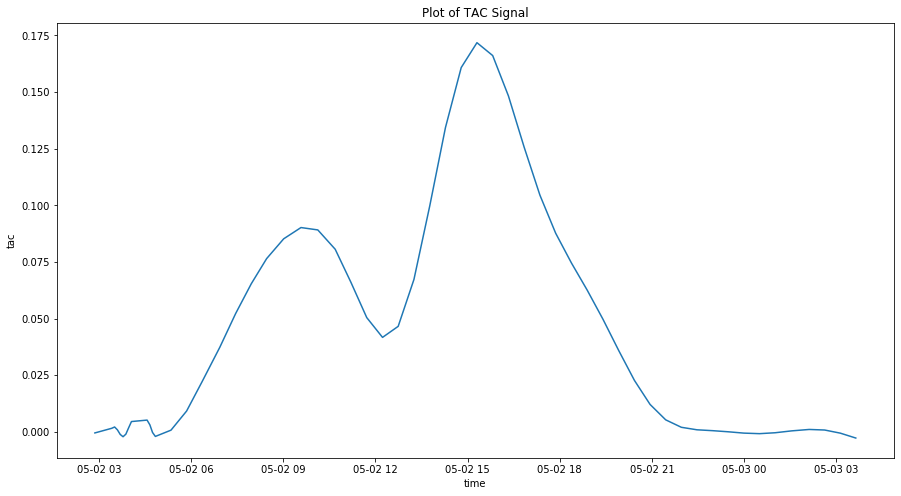

In [2]:
# Quick look at TAC data
df = pd.read_csv(os.path.join('data', 'clean_tac', 'BK7610_clean_TAC.csv'))
print(df.head())
_, _ = plt.subplots(figsize=(15,8))
plt.plot(df['timestamp'].map(datetime.fromtimestamp), df['TAC_Reading'])
plt.xlabel('time')
plt.ylabel('tac')
plt.title('Plot of TAC Signal')
plt.show()

### Time Domain
The samples can be transformed into temporal and frequency information that would represent how the pariticipant was moving during that time frame. From domain knowledge, we may assume intoxicated movements to be somewhat irregular. However, human beings do not move continuously and we only have a 10 second window to analyze. Temporal infomation may not tell us much. Let's analyze using plots.

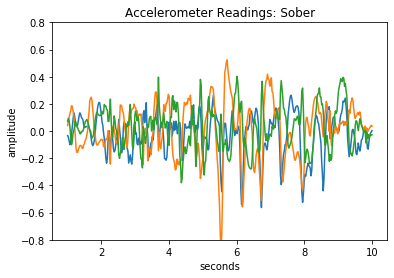

In [3]:
# Setup
tac1 = pd.read_csv(os.path.join('data', 'clean_tac', 'BK7610_clean_TAC.csv'))
acc1 = acc_df[acc_df.pid == 'BK7610'].copy()
acc1['timestamp'] = acc1.time.map(lambda x:x//1000)
acc1 = pd.merge(acc1,tac1, on='timestamp', how='left')
acc1.timestamp.value_counts()

# Time plot
x = acc1[acc1.TAC_Reading == np.sort(acc1.TAC_Reading.unique())[0]]
start, end = x.timestamp.iloc[0], x.timestamp.iloc[0]+9
min_tac_df = acc1[(start <= acc1.timestamp) & (acc1.timestamp <= end)]
plot_series(min_tac_df, "Sober")

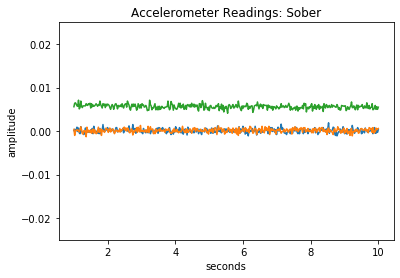

In [4]:
x = acc1[acc1.TAC_Reading == np.sort(acc1.TAC_Reading.unique())[1]]
start, end = x.timestamp.iloc[0], x.timestamp.iloc[0]+9
min_tac_df = acc1[(start <= acc1.timestamp) & (acc1.timestamp <= end)]
plot_series(min_tac_df, "Sober", -0.025, 0.025)

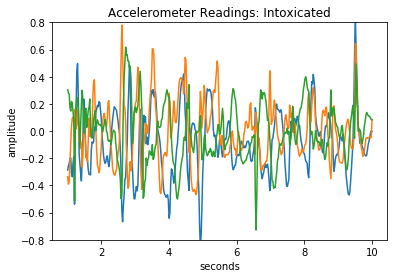

In [5]:
x = acc1[acc1.TAC_Reading == np.sort(acc1.TAC_Reading.unique())[::-1][6]]
start, end = x.timestamp.iloc[0], x.timestamp.iloc[0]+9
max_tac_df = acc1[(start <= acc1.timestamp) & (acc1.timestamp <= end)]
plot_series(max_tac_df, "Intoxicated")

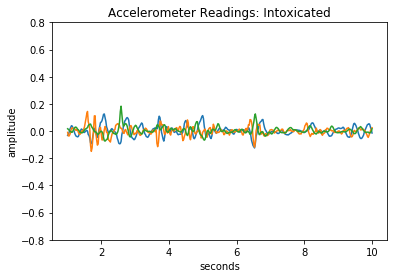

In [6]:
x = acc1[acc1.TAC_Reading == np.sort(acc1.TAC_Reading.unique())[::-1][1]]
start, end = x.timestamp.iloc[0], x.timestamp.iloc[0]+9
max_tac_df = acc1[(start <= acc1.timestamp) & (acc1.timestamp <= end)]
plot_series(max_tac_df, "Intoxicated")

The signal plots look different even within the same class. There seem to be more peaks and variance in the plots for intoxicated class.

### Frequency Domain
We can see a lot of variation in frequency domain within the same class as well.

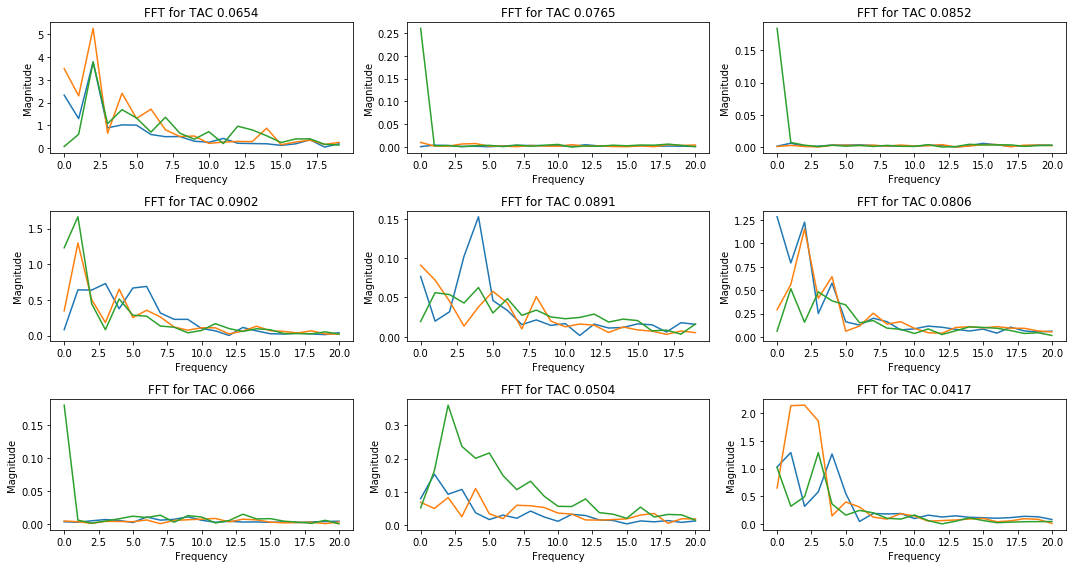

In [7]:
sel_df = acc1[acc1.TAC_Reading.notna()][['timestamp', 'TAC_Reading']].drop_duplicates()
start_times, end_times = sel_df.timestamp, sel_df.timestamp+9
fig, axes = plt.subplots(3,3, figsize=(15,8))
times = list(zip(start_times[:9], end_times[:9]))
for i, ax in enumerate(axes.flat):
    start, end = times[i]
    ax.set_title(f"FFT for TAC {np.round(sel_df.TAC_Reading.iloc[i],4)}")
    df = acc1[acc1.TAC_Reading.notna() & (acc1.TAC_Reading==sel_df.TAC_Reading.iloc[i])]
    ax.plot(np.abs(np.fft.rfft(df.x)))
    ax.plot(np.abs(np.fft.rfft(df.y)))
    ax.plot(np.abs(np.fft.rfft(df.z)))
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Magnitude')
fig.tight_layout()
plt.show()

### Spectral Information
Here, we combine frequency and time information in the same plot using Short-Term Fourier Transform spectrograms.

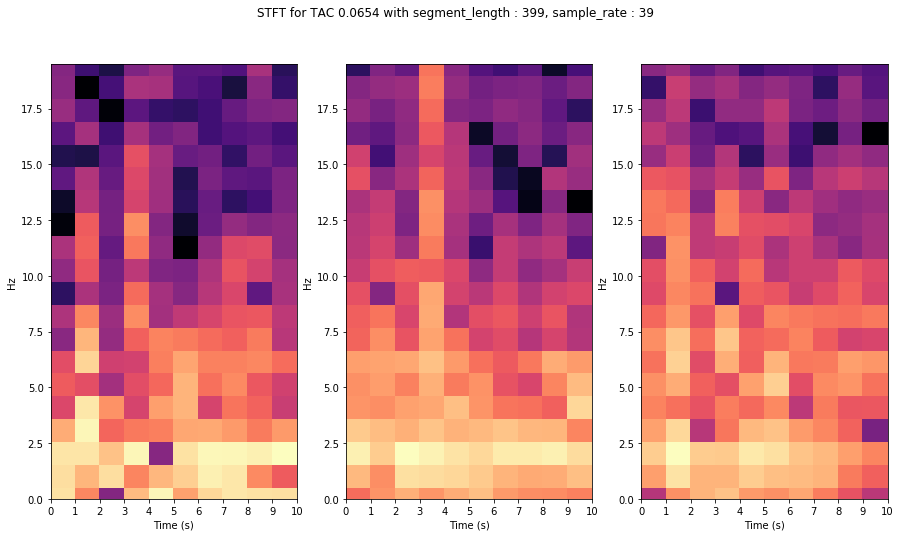

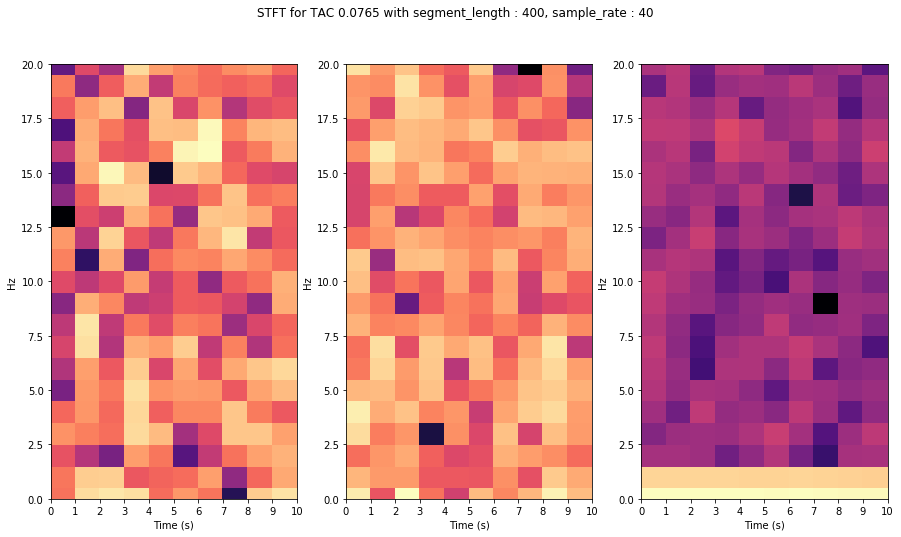

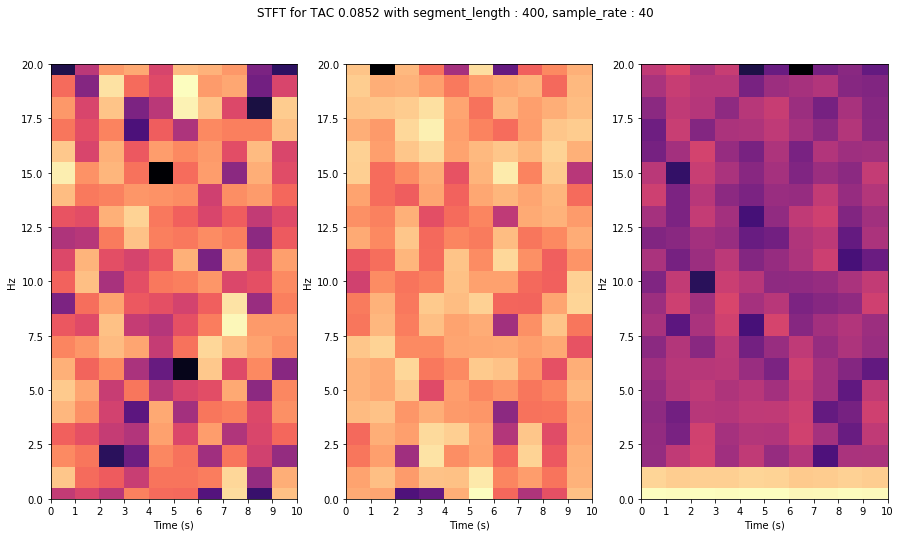

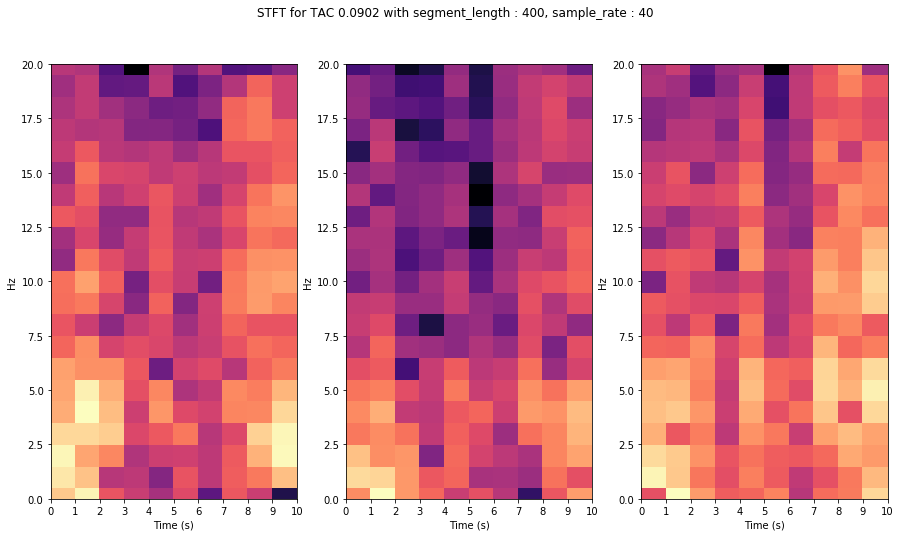

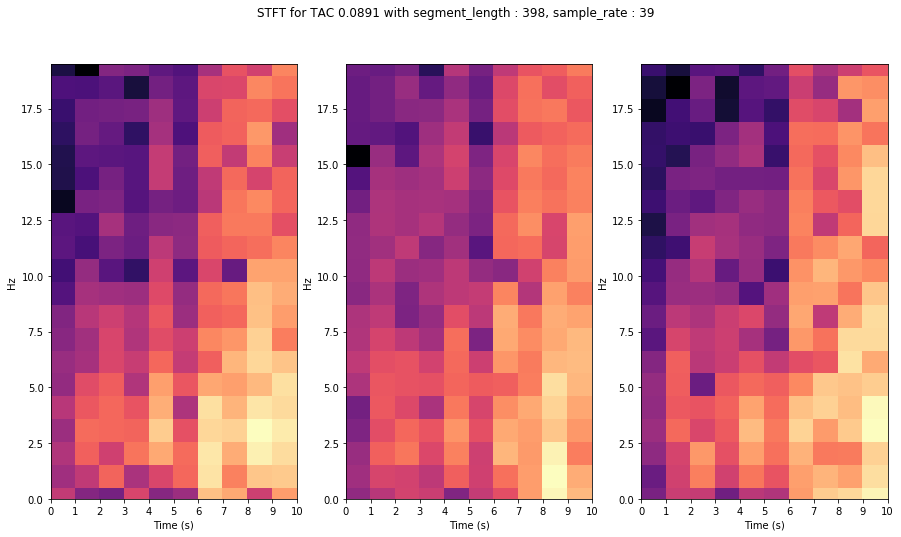

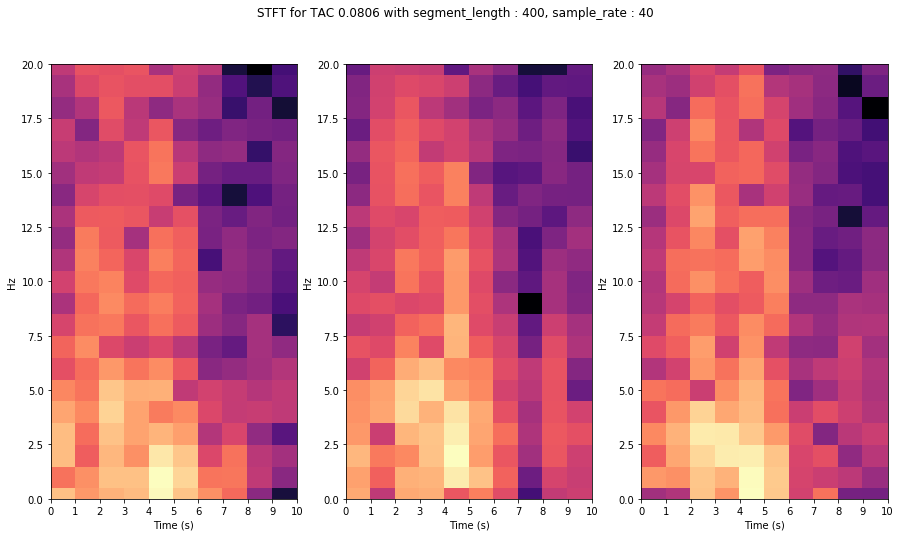

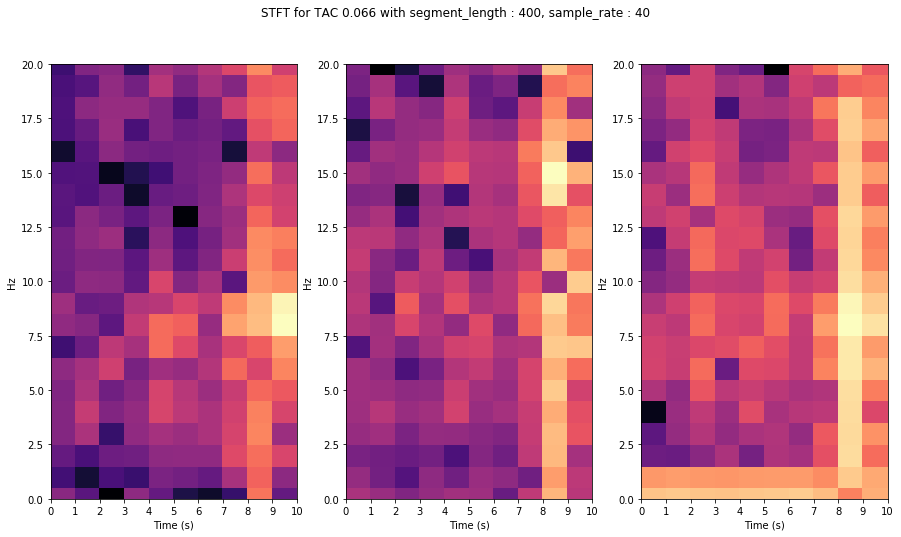

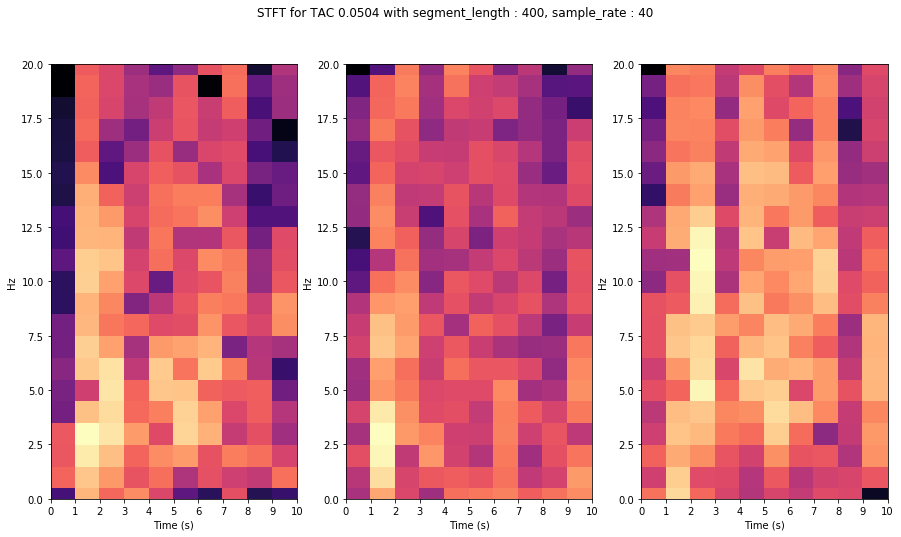

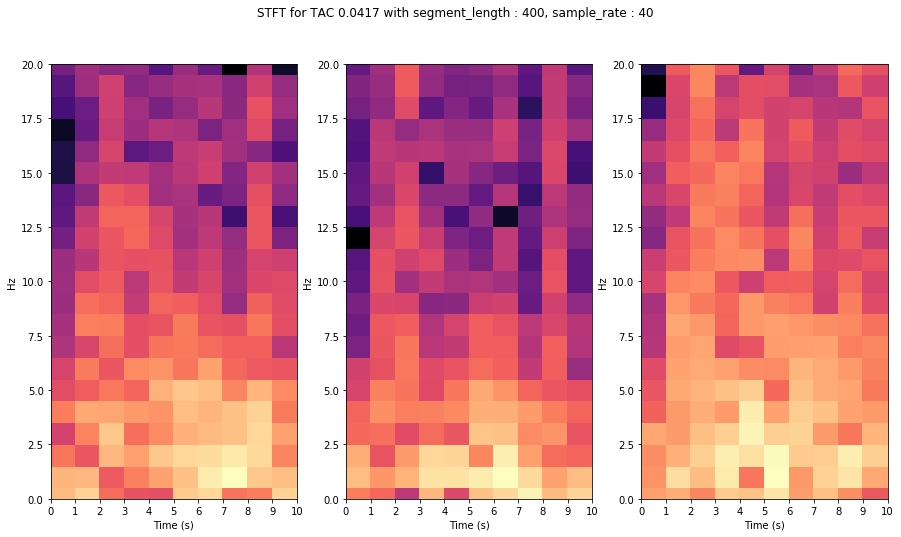

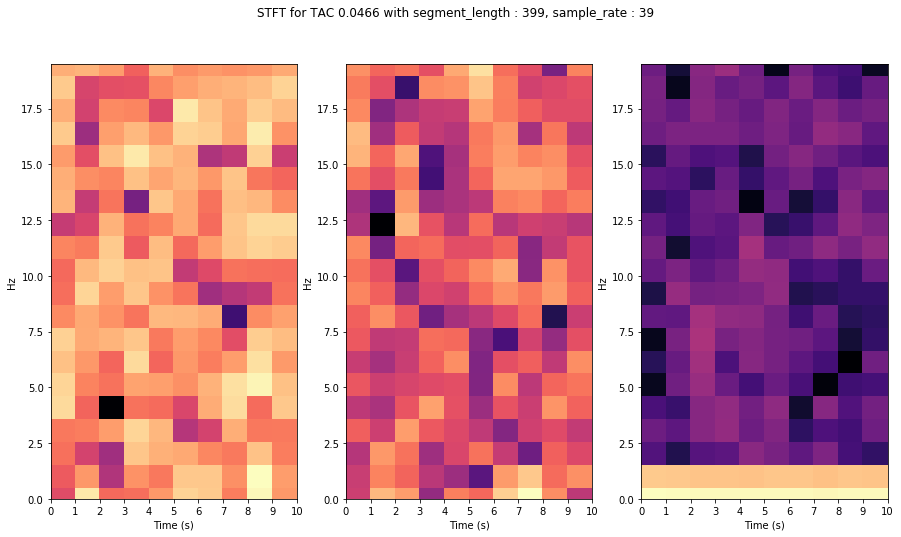

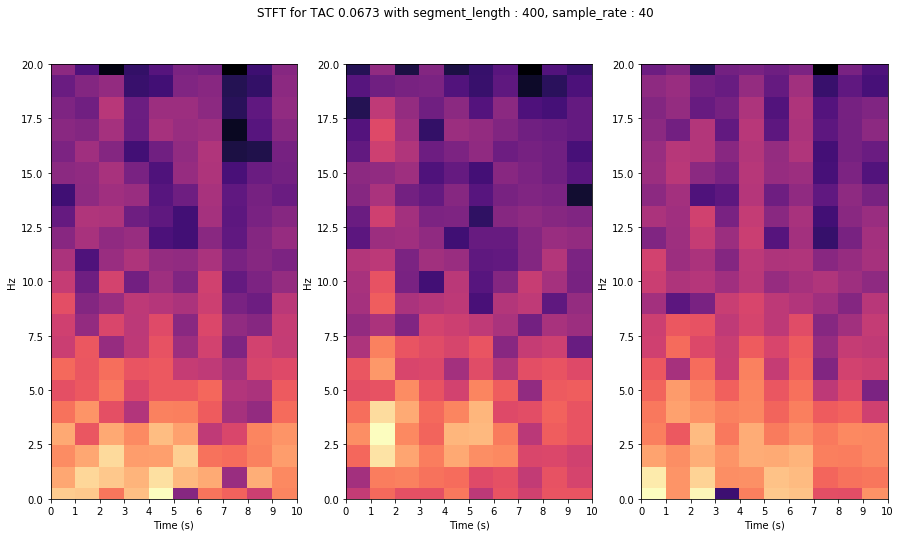

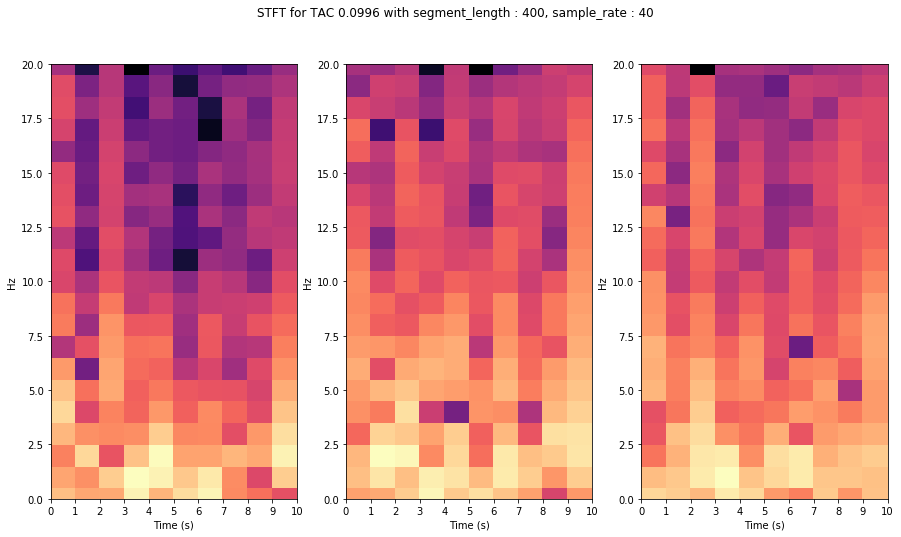

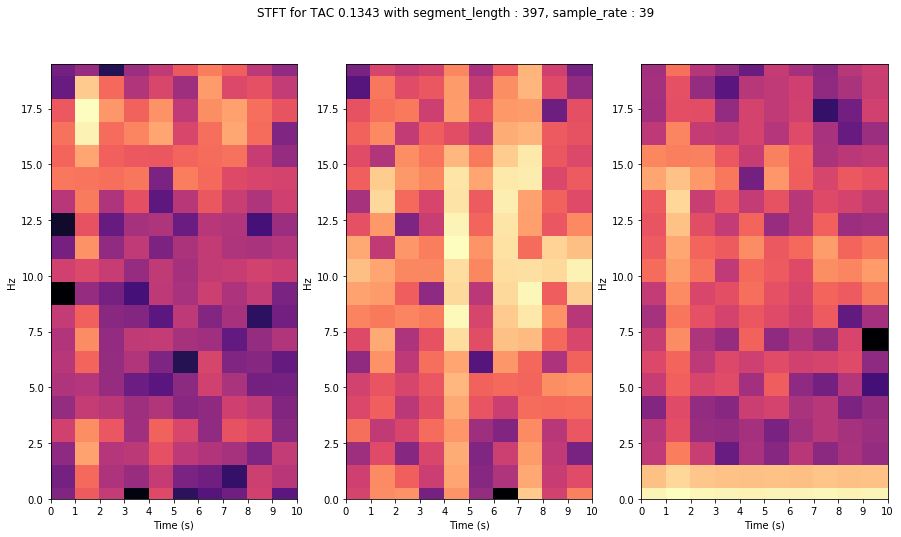

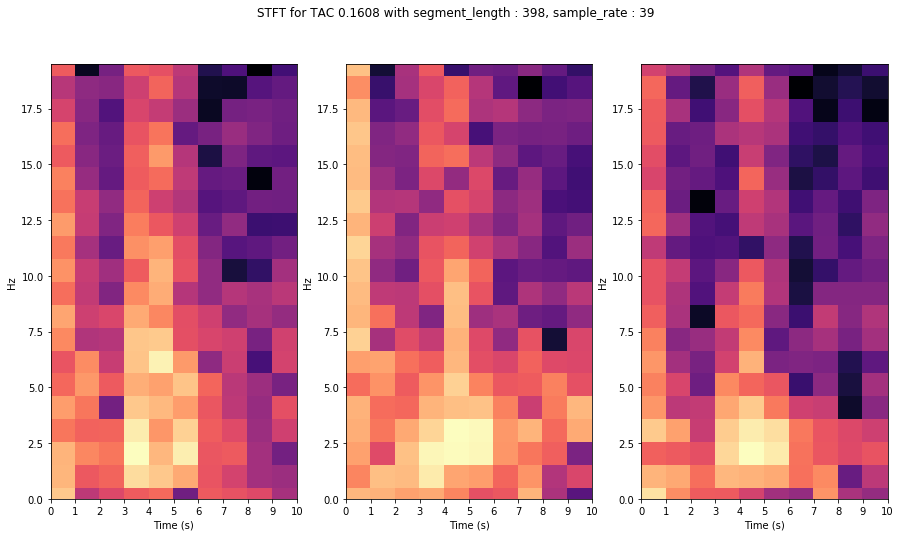

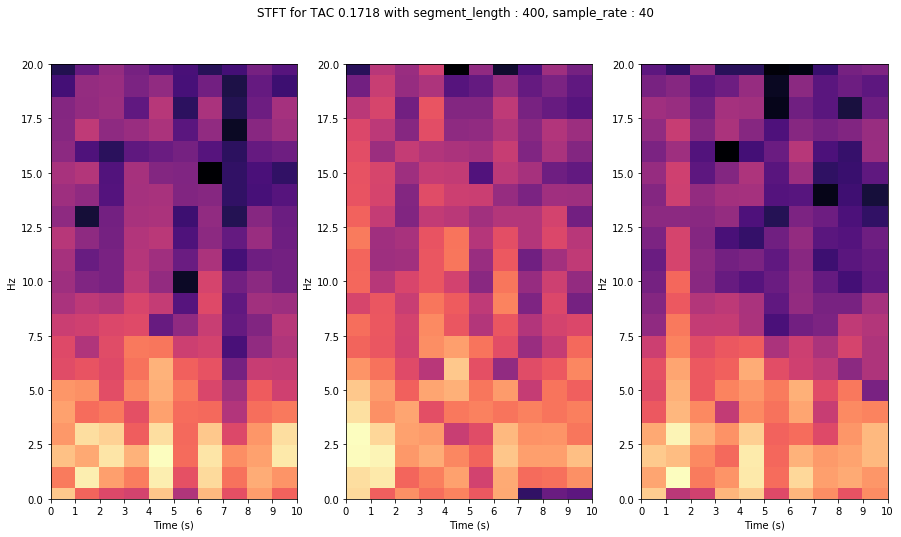

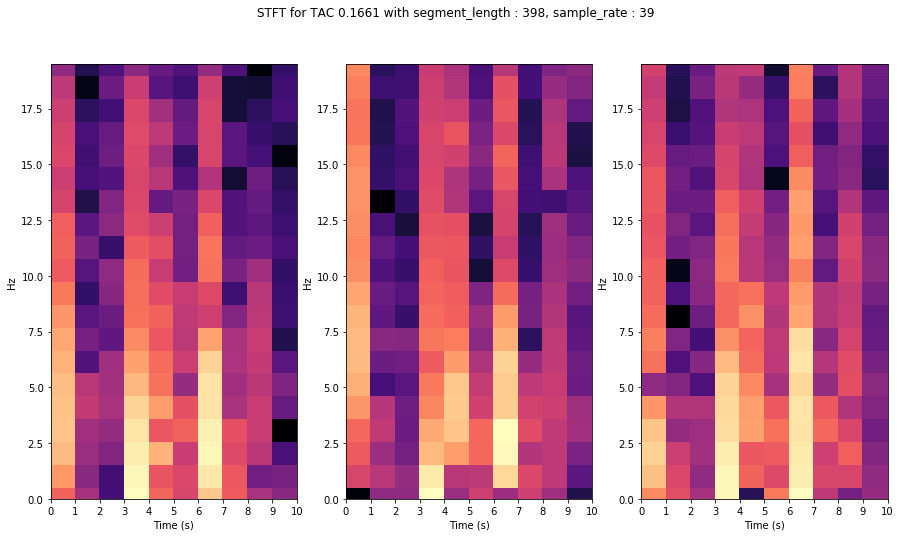

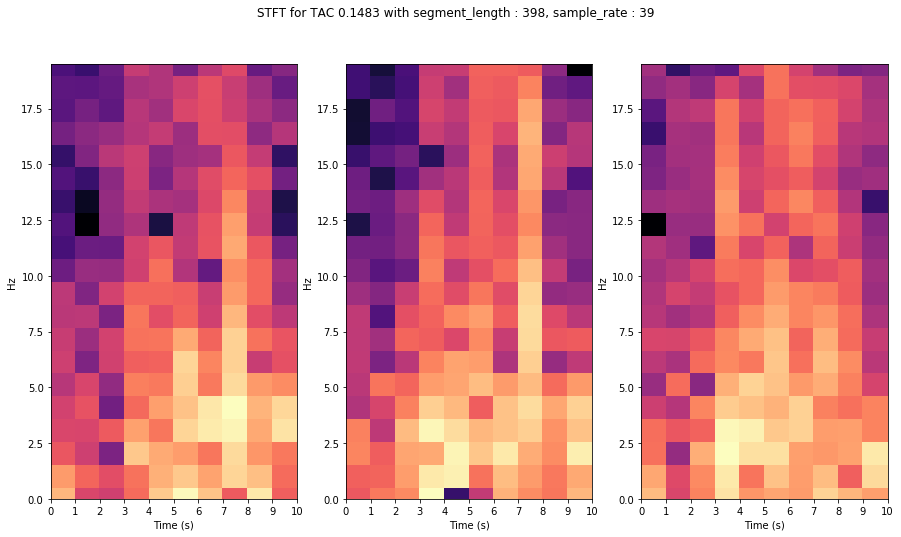

In [8]:
num_frames = 10   

start_times = acc1[acc1['TAC_Reading'].notna()].timestamp.unique()
start_times.sort()
end_times = start_times+9
for start, end in zip(start_times, end_times):
    df = acc1[(start <= acc1.timestamp) & (acc1.timestamp <= end)]
    plot_stft(df)
    plt.show()

The spectrograms do not have any obvious patterns for us to recognize the intoxication level. However, with enough combined frequency and temporal information, we can train a classifier to predict whether the user is intoxicated or not.

## Data
I used `clean_tac` data, which contains the cleaned TAC Readings for each participant.
- Join TAC readings with accelerometer data
- Sort the accelerometer data based on `time` column, which is the unix millisecond recording timestamp.
- Extract signals of window length 10 seconds and frame length 40 samples.
- Feature extraction of temporal and frequency information

Things to deal with
- Accelerometer sampling rate is not 40 hz consistently
    - Removed signsls with less than 375 samples or more than 425 samples in 10 second window and resampled the filtered signals to 40 hz.
- TAC Readings are not exactly once every 30 minutes
- Joining the datasets is not entirely straightforward.
    - Timestamp unit of TAC data is in seconds while the accelerometer timestamps are in milliseconds
    - Converted timestamps do not align completely
    - Interploration technique was used to find missing TAC_Reading information

### Missing Data and Cleaning

Here, we check if sample_rate is consistent for all 10 second accelerometer data corresponding to TAC Readings. Higher number of samples can be resampled into 40 hz. Hence, let's check undersampled sections

In [9]:
tac2 = pd.read_csv('data/clean_tac/JB3156_clean_TAC.csv')
acc2 = acc_df[acc_df.pid == 'JB3156'].copy()
acc2['timestamp'] = acc2.time.map(lambda x:x//1000)
acc2 = pd.merge(acc2,tac2, on='timestamp', how='left')
start_times = acc2[acc2['TAC_Reading'].notna()].timestamp.unique()
start_times.sort()
end_times = start_times+9

for start, end in zip(start_times, end_times):
    df = acc2[(start <= acc2.timestamp) & (acc2.timestamp <= end)]
    if df.shape[0] < 300:
        print(df.groupby('timestamp')['timestamp'].agg('count'))

timestamp
1493749820    50
1493749821    50
1493749822    44
1493749827    23
1493749828    50
1493749829    49
Name: timestamp, dtype: int64
timestamp
1493779295    48
1493779302    25
1493779303     7
Name: timestamp, dtype: int64
timestamp
1493782978    17
1493782986    24
1493782987    43
Name: timestamp, dtype: int64


As we can see, there are multipe seconds that are sampled at less than 40 hz. There are also sections which do not have complete 10 seconds of accelerometer signal.

### Data Transformation

Let's join all TAC Readings so that we can join the readings with the accelerometer data.

In [10]:
def tac_readings(pid):
    fname = glob.glob(os.path.join('data', 'clean_tac', f'{pid}*.csv'))[0]
    df = pd.read_csv(fname)
    df['pid'] = pid
    return df
all_tacs = pd.concat(pids.pid.apply(tac_readings).to_list())
all_tacs.head()

,timestamp,TAC_Reading,pid
0,1493718714,-0.000482,BK7610
1,1493720697,0.001573,BK7610
2,1493721027,0.002144,BK7610
3,1493721357,0.000877,BK7610
4,1493721686,-0.001145,BK7610


#### Join Method: Inflate TAC Readings
In this method, we inflate the TAC Readings to cover the 10 second window by duplicating each entry 9 times for t+1 to t+9 seconds. I would use the resulting dataframe to find matches in the accelerometer dataset. I find the corresponding timestamp in seconds for each accelerometer recording by dividing the unix timestamp by 1000.

In [11]:
# inflate dataframe to cover 10 seconds.
all_tacs_full = pd.DataFrame()

def inflate(row):
    global all_tacs_full
    for i in range(10):
        all_tacs_full = all_tacs_full.append([[row.timestamp+i, row.TAC_Reading, row.pid]])

all_tacs.apply(inflate, axis=1)
all_tacs_full.reset_index(drop=True, inplace=True)
all_tacs_full.columns = all_tacs.columns
all_tacs_full

,timestamp,TAC_Reading,pid
0,1493718714,-0.000482,BK7610
1,1493718715,-0.000482,BK7610
2,1493718716,-0.000482,BK7610
3,1493718717,-0.000482,BK7610
4,1493718718,-0.000482,BK7610
...,...,...,...
7145,1493805315,-0.002919,SF3079
7146,1493805316,-0.002919,SF3079
7147,1493805317,-0.002919,SF3079
7148,1493805318,-0.002919,SF3079


##### Limited Signals

In [12]:
# now merge with accelerator df
# pd.merge(acc_df, all_tacs_full, on=[''])
acc_df['timestamp'] = acc_df.time // 1000
acc_df_merged = pd.merge(acc_df, all_tacs_full, on=['timestamp', 'pid'], how='left')
X = acc_df_merged[acc_df_merged.TAC_Reading.notna()]

In [13]:
print(f"Total number of input signals assuming 40 hz sampling rate = {X.shape[0]//400}")

Total number of input signals assuming 40 hz sampling rate = 154


The issue with the above method is there are very few matches between the two dataframes based on timestamp (seconds). We cannot reliably train a classifier with limited data.

##### Invalid Sampling Rate
Another issue is that not all time windows have enough accelerometer data samples.

In [14]:
# for start in starts:
windowed = pd.DataFrame()
def segment(pid):
    global windowed
    starts = all_tacs[all_tacs.pid==pid].timestamp
    recorded_timestamps = set(X.timestamp)
    for start in starts:
        if start in recorded_timestamps:
            df = X[(X.pid==pid) & ((start <= X.timestamp) & (X.timestamp <= start+9))]
            df = df.sort_values(by=['time'])
            if df.shape[0] > 350 and df.shape[0] < 450:
                windowed = windowed.append([[df.iloc[0].pid, df.iloc[0].timestamp, df.x.values, df.y.values, df.z.values, df.iloc[0].TAC_Reading]])
            else:
                print(f"Bad 10 second window: with {df.shape[0]} samples starting at {start} for {pid}")
_ = pids.pid.map(segment)
windowed.columns = ['pid', 'start_time_s', 'x', 'y', 'z', 'TAC']

Bad 10 second window: with 0 samples starting at 1493737046 for BU4707
Bad 10 second window: with 0 samples starting at 1493738847 for BU4707
Bad 10 second window: with 0 samples starting at 1493740845 for BU4707
Bad 10 second window: with 0 samples starting at 1493742871 for BU4707
Bad 10 second window: with 0 samples starting at 1493756113 for BU4707
Bad 10 second window: with 0 samples starting at 1493757960 for BU4707
Bad 10 second window: with 0 samples starting at 1493759807 for BU4707
Bad 10 second window: with 0 samples starting at 1493761652 for BU4707
Bad 10 second window: with 0 samples starting at 1493763497 for BU4707
Bad 10 second window: with 0 samples starting at 1493765341 for BU4707
Bad 10 second window: with 0 samples starting at 1493767186 for BU4707
Bad 10 second window: with 106 samples starting at 1493741188 for CC6740
Bad 10 second window: with 195 samples starting at 1493772526 for CC6740
Bad 10 second window: with 37 samples starting at 1493776216 for CC6740
B

We can see that invalid sampling rate further reduces the amount of data we have to train a classifier on. For example, not data for PID 'SA0297' is in the transformed dataframe!

In [15]:
windowed.pid.value_counts()

PC6771    19
CC6740    19
BK7610    17
DK3500    16
HV0618    15
SF3079     9
MJ8002     8
DC6359     8
BU4707     6
MC7070     5
JR8022     3
JB3156     1
Name: pid, dtype: int64

#### Join Method: Using Interpolation
Since I did not find enough matches when joining the dataframes due to timestamp mismatches or invalid sampling rate, I decided to not perform join at all. Instead, I use interpolation to find the TAC reading for the valid ten-second windows that exist in the accelerometer dataframe. Linear interpolation worked best for this purpose. Let's compare actual and interpolated TAC values for `SA0297`, since that's the PID that didn't have any valid windows using the previous method.

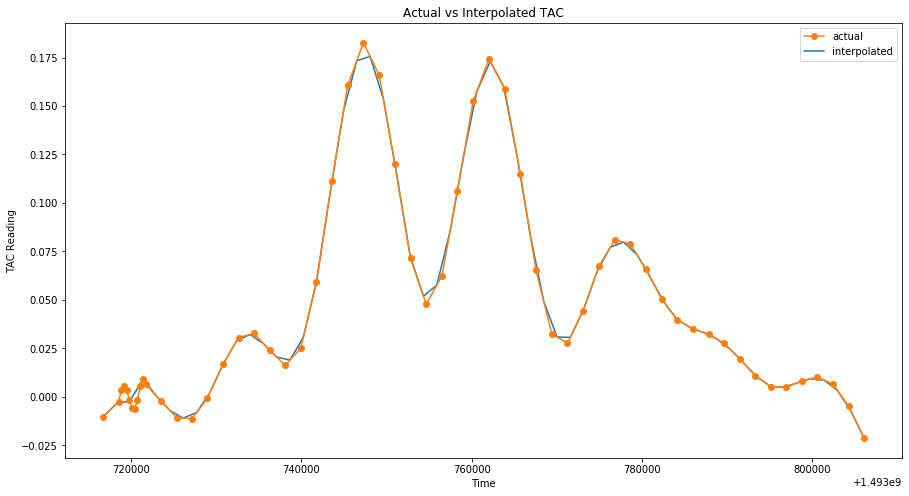

In [16]:
sa = all_tacs[all_tacs.pid=='SA0297']
ts = np.linspace(sa.timestamp.min(), sa.timestamp.max(), sa.timestamp.shape[0])
fig, ax = plt.subplots(figsize=(15,8))
f = interp1d(sa.timestamp, sa.TAC_Reading, kind='linear')
i, = ax.plot(ts, f(ts))
a, = ax.plot(sa.timestamp, sa.TAC_Reading, '-o')
plt.xlabel('Time')
plt.ylabel('TAC Reading')
plt.title('Actual vs Interpolated TAC')
plt.legend([a,i], ['actual', 'interpolated'])
plt.show()

##### Transformation Process

Using the interpolation method, we can transform the dataset as follows

- Filter accelerometer and TAC data for PID
- Extract accelerometer data between start and end times of TAC measurement
- Pick valid 10 second windows with 40 sample rate.
- Find interpolated TAC reading for each window.
- Append to new dataframe with vectorized x,y and z values
- Repeat for other participants (PIDs)

Let's create the full converted data set using interpolation method for each pid

In [17]:
# setup acc_df
acc_df = pd.read_csv(os.path.join('data', 'all_accelerometer_data_pids_13.csv'))
# sort by time of recording the data
acc_df.sort_values(by=['time'], inplace=True)
# create column with timestamp in seconds
acc_df['timestamp'] = acc_df['time']//1000
# setup all_tacs
pids = pd.read_csv(os.path.join('data', 'phone_types.csv'))
def tac_readings(pid):
    fname = glob.glob(os.path.join('data', 'clean_tac', f'{pid}*.csv'))[0]
    df = pd.read_csv(fname)
    df['pid'] = pid
    return df
all_tacs = pd.concat(pids.pid.apply(tac_readings).to_list())
# sort by timestamp
all_tacs.sort_values(by=['timestamp'], inplace=True)

In [18]:
def extract_segments(pid):
    # filter accelerometer readings for the pid
    acc_pid = acc_df[acc_df.pid == pid]
    # get TAC readings for the pid
    tacs_pid = all_tacs[all_tacs.pid == pid]
    # interpolation function for TAC readings of pid
    expected_tac = interp1d(tacs_pid.timestamp, tacs_pid.TAC_Reading, kind='linear')
    # get the start and end time for the TAC readings in seconds
    start, end = tacs_pid.timestamp.min(), tacs_pid.timestamp.max()
    # extract accelerator readings in the time frame TAC has been active
    acc_pid = acc_pid[(start <= acc_pid.timestamp) & (acc_pid.timestamp <= end)]
    acc_pid = acc_pid.sort_values(by=['time'])
    # 10 seconds grouping window
    acc_pid['ten_seconds_group'] = acc_pid.timestamp//10
    # select groups with 40 Hz sampling rate
    samples_in_groups = acc_pid.ten_seconds_group.value_counts()
    valid_groups = samples_in_groups[samples_in_groups == 400].index
    valid_groups_acc_pid = acc_pid[acc_pid['ten_seconds_group'].isin(valid_groups)]
    grouped = valid_groups_acc_pid.groupby('ten_seconds_group').agg(lambda s: s.to_list())
    grouped = grouped[['x', 'y', 'z', 'timestamp']]
    grouped['timestamp'] = grouped.timestamp.map(lambda x: x[0])
    grouped['tac'] = grouped.timestamp.map(lambda x: expected_tac(x))
    grouped['pid'] = pid
    return grouped

X = pd.concat(pids.pid.map(extract_segments).to_list())
X.pid.value_counts()

BK7610    1402
PC6771    1344
CC6740     965
SF3079     604
BU4707     479
MC7070     372
MJ8002     331
JR8022     273
HV0618      91
DK3500      11
JB3156       2
Name: pid, dtype: int64

##### Resampled Signals
By using interpolation, we got over 5000 records/signals for training. One thing to note is that there are a lot of sections sampled at higher than 40 hz. For example, for pid `JB3156`
```
1493760428    78
1493760426    50
1493760424    50
1493760423    50
1493760421    50
1493760420    50
1493760429    49
1493760427    49
1493760425    49
1493760422    49
```

Let us create a separate dataframe with resampled signals. We can train a classifier with and without resampled data and pick the one that performs the best.



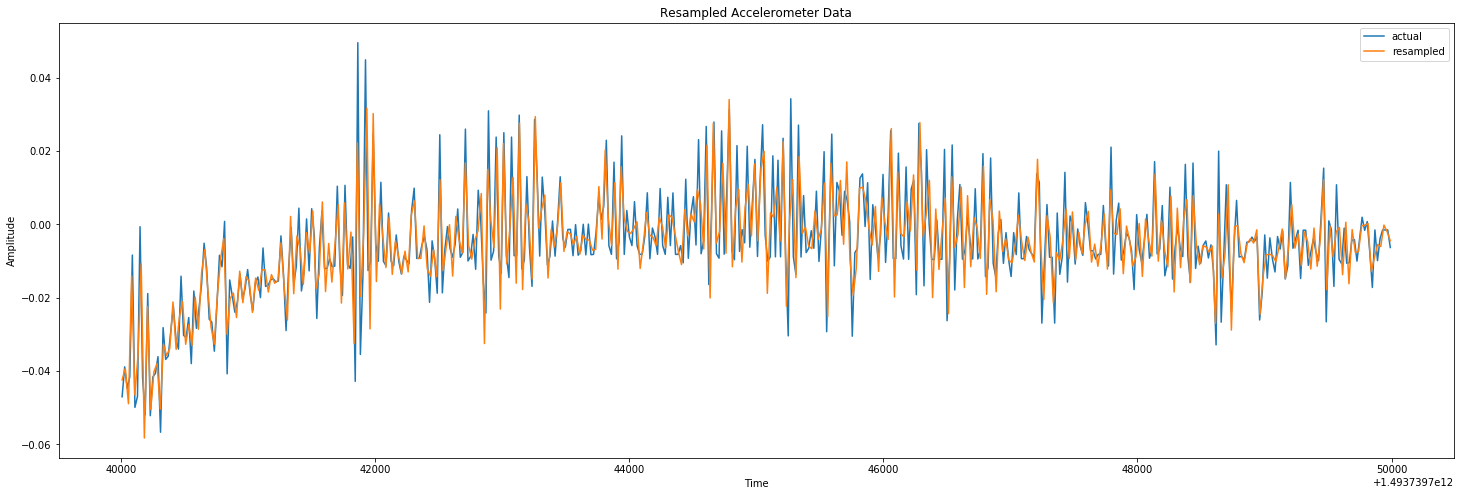

In [19]:
xs = acc_df[(acc_df.pid == 'JB3156') & (acc_df.timestamp >= 1493739740) & (acc_df.timestamp <= 1493739749)]
fig, ax = plt.subplots(figsize=(25,8))
ts = np.linspace(xs.time.min(), xs.time.max(), 496)
a, = ax.plot(ts, xs.x)
ts = np.linspace(xs.time.min(), xs.time.max(), 400)
r, = ax.plot(ts, librosa.resample(np.array(xs.x), len(xs), 400))
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title("Resampled Accelerometer Data")
plt.legend([a, r], ["actual", "resampled"])
plt.show()

From the plot, we can see that the resampled signal is very similar to the original

In [20]:
sample_rate = 400
def extract_segments_with_resample(pid):
    # filter accelerometer readings for the pid
    acc_pid = acc_df[acc_df.pid == pid]
    # get TAC readings for the pid
    tacs_pid = all_tacs[all_tacs.pid == pid]
    # interpolation function for TAC readings of pid
    expected_tac = interp1d(tacs_pid.timestamp, tacs_pid.TAC_Reading, kind='linear')
    # get the start and end time for the TAC readings in seconds
    start, end = tacs_pid.timestamp.min(), tacs_pid.timestamp.max()
    # extract accelerator readings in the time frame TAC has been active
    acc_pid = acc_pid[(start <= acc_pid.timestamp) & (acc_pid.timestamp <= end)]
    acc_pid = acc_pid.sort_values(by=['time'])
    # 10 seconds grouping window
    acc_pid['ten_seconds_group'] = acc_pid.timestamp//10
    # select groups with 40 Hz sampling rate
    samples_in_groups = acc_pid.ten_seconds_group.value_counts()
    valid_groups = samples_in_groups[(samples_in_groups != 400) & (samples_in_groups > 375) & (samples_in_groups < 425)].index
    valid_groups_acc_pid = acc_pid[acc_pid['ten_seconds_group'].isin(valid_groups)]
    grouped = valid_groups_acc_pid.groupby('ten_seconds_group').agg(lambda s: s.to_list())
    grouped = grouped[['x', 'y', 'z', 'timestamp']]
    grouped['x'] = grouped['x'].apply(lambda x: librosa.resample(np.array(x), len(x), sample_rate))
    grouped['y'] = grouped['y'].apply(lambda x: librosa.resample(np.array(x), len(x), sample_rate))
    grouped['z'] = grouped['z'].apply(lambda x: librosa.resample(np.array(x), len(x), sample_rate))
    grouped['timestamp'] = grouped.timestamp.map(lambda x: x[0])
    grouped['tac'] = grouped.timestamp.map(lambda x: expected_tac(x))
    grouped['pid'] = pid
    return grouped

X_rescaled = pd.concat(pids.pid.map(extract_segments_with_resample).to_list())
X_rescaled.pid.value_counts()

DK3500    2778
HV0618    2688
CC6740    2325
PC6771    2257
BK7610    1661
DC6359    1535
MJ8002    1243
SF3079    1047
BU4707     631
JR8022     489
MC7070     418
JB3156     174
Name: pid, dtype: int64

### Feature Extraction Pipeline

The initial features I am extracting from the signals are RMS values of each frame in the segment and average of the STFT spectral information for each frame

In [21]:
class NumpyArrayConvertor():
    def transform(self, X, **fit_params):
        X['x'] = X['x'].apply(np.array)
        X['y'] = X['y'].apply(np.array)
        X['z'] = X['z'].apply(np.array)
        return X
    def fit(self, X, y=None, **fit_params):
        return self

class RMSCalculator():
    def transform(self, X, **fit_params):
        X['rms_x'] = X['x'].apply(rms)
        X['rms_y'] = X['y'].apply(rms)
        X['rms_z'] = X['z'].apply(rms)
        return X
    def fit(self, X, y=None, **fit_params):
        return self

class STFTCalculator():
    def transform(self, X, **fit_params):
        X['stft_x'] = X['x'].map(avg_stft_per_frame)
        X['stft_y'] = X['y'].map(avg_stft_per_frame)
        X['stft_z'] = X['z'].map(avg_stft_per_frame)
        return X
    def fit(self, X, y=None, **fit_params):
        return self

class FeaturesFlattener():
    def __init__(self, feature_cols):
        self.feature_cols = feature_cols
    def transform(self, X, **fit_params):
        return pd.concat([pd.DataFrame(X[c].tolist()) for c in feature_cols], axis=1).values
    def fit(self, X, y=None, **fit_params):
        return self

def rms(x):
    return librosa.feature.rms(x, frame_length=frame_length, hop_length=frame_length, center=False)[0]

def avg_stft_per_frame(x):
    stft = librosa.amplitude_to_db(np.abs(librosa.stft(x, n_fft=frame_length, hop_length=frame_length, center=False)), ref=np.max)
    return stft.mean(axis=1)

# Values
sample_rate = 40
frame_length = sample_rate
feature_cols = ['rms_x', 'rms_y', 'rms_z', 'stft_x', 'stft_y', 'stft_z']

# Feature Extraction Pipeline
pl = Pipeline([("Convert signals to numpy arrays", NumpyArrayConvertor()),
               ("Calculate RMS values for signals", RMSCalculator()),
               ("Calculate average STFT vectors", STFTCalculator()),
               ("Flatten features into a 2D numpy array", FeaturesFlattener(feature_cols))
              ])

# y == True if TAC level > 0.8
y = (X.tac > 0.08).values
features = pl.fit_transform(X.copy())
np.save(os.path.join('cache', 'features'), features)
np.save(os.path.join('cache', 'y'), y)

y_rescaled = (X_rescaled.tac > 0.08).values
features_rescaled = pl.fit_transform(X_rescaled.copy())
np.save(os.path.join('cache', 'features_rescaled'), features_rescaled)
np.save(os.path.join('cache', 'y_rescaled'), y_rescaled)

## Classification

In [22]:
features = np.load(os.path.join('cache', 'features.npy'))
y = np.load(os.path.join('cache', 'y.npy'))
features_rescaled = np.load(os.path.join('cache', 'features_rescaled.npy'))
y_rescaled = np.load(os.path.join('cache', 'y_rescaled.npy'))
print(f"The percentage of records for 'Intoxicated' class in the dataset is {np.round(y.mean(),3) * 100}")
print(f"The percentage of records for 'Intoxicated' class in the rescaled set is {np.round(y_rescaled.mean(),3) * 100}")

The percentage of records for 'Intoxicated' class in the dataset is 41.5
The percentage of records for 'Intoxicated' class in the rescaled set is 26.1


#### Process
- Shuffle the dataset to reduce overfitting
- Split the dataset into training (80%) and testing (20%) sets. Make sure class representation is equal in both sets.
- Set a seed for random state for reproducibility
- Train the classifiers
- Examine classification report and accuracy
- Cross validation
- Hyperparameter tuning through grid search

I combined accurately sampled signals with resampled signals to increase the size of the dataset to reduce overfitting. The accuracy of the models dropped a little after adding the resampled data to the dataset. However, this is still desirable to do since we need to know how well the model generalizes

I performed hyperparameter tuning with cross validation on the training set. Then, I retrained the best estimator on the entire training set and evaluated it against the test set. The hold out test set thus acted as a validation set.

In [23]:
X_full = np.vstack([features, features_rescaled])
y_full = np.concatenate([y, y_rescaled])
np.save(os.path.join('cache', 'X'), X_full)
np.save(os.path.join('cache', 'y'), y_full)
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, shuffle=True, stratify=y_full, random_state=1337)
print(f"Distribution of Intoxicated class in the full dataset is {np.round(y_full.mean(), 3) * 100}")

Distribution of Intoxicated class in the full dataset is 30.0


### Random Forest
Random Forest Classifier is a good fit for this task since it is fast and it can be trained on datasets with non-linear features and unbalanced class distributions. I set the Random Forest Classifier to run on all CPU cores and was able to bring down cross validation time for each model from 90 seconds to 20 seconds on a 4.2 Ghz Quad-core iMac

In [24]:
%%time
parameters = {'n_estimators': (20, 50, 100, 300, 500, 750), 'criterion': ('gini', 'entropy'), 'max_depth': (2, 5, 10), 'max_features':(0.2, 0.3, 'sqrt', 'log2'),
             'class_weight':[{True: w} for w in [1, 1.2, 1.5, 2]]}
rfc = RandomForestClassifier(random_state=1337, n_jobs=-1)
clf = GridSearchCV(rfc, parameters, n_jobs=-1)
clf.fit(X_train, y_train)
clf.best_estimator_

The best performing estimator had the highest F1 score (0.83), but the true class accuracy (recall) was 5 points lower. Since "Intoxicated" class only makes up 30% of the dataset, I increased its class weight, which increased the accuracy of the model at predicting intoxication. I took the best parameters and increased class weight for "Intoxicated" to improve the model's performance at identifying intoxicated patterns. The final Random Forest model is as follows, with overall, sober and intoxicated accuracies above 80%. 

Cross validation F1 scores: [0.82399798 0.83209913 0.82430832 0.81408841 0.81501855]
Average cross validation F1: 0.8219024787524412
Cross validation time: 5.787461042404175 seconds
Time taken to train on full training set: 1.033534049987793 seconds

              precision    recall  f1-score   support

       Sober       0.91      0.81      0.86      3236
 Intoxicated       0.64      0.80      0.72      1388

    accuracy                           0.81      4624
   macro avg       0.78      0.81      0.79      4624
weighted avg       0.83      0.81      0.81      4624

Overall accuracy: 0.8079584775086506
Sober accuracy: 0.8099505562422744
Intoxicated accuracy: 0.803314121037464


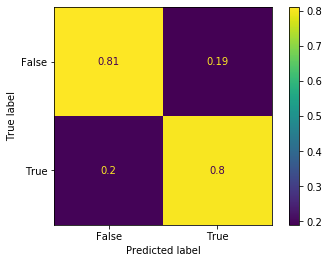

CPU times: user 6.9 s, sys: 188 ms, total: 7.09 s
Wall time: 6.95 s


In [25]:
%%time
clf = RandomForestClassifier(class_weight={True: 1.5}, criterion='gini',
                             max_depth=10, max_features=0.3,
                             n_estimators=20, n_jobs=-1, random_state=1337)
clf_report(clf, X_train, y_train, X_test, y_test)

### Multi-layer Perceptron
Multi-layer perceptron is another ML model that can be trained on non-linear data. Before running grid search, I ruled out some parameters using manual validation to reduce grid search execution time. For example, I ruled out lbfgs solver, identity and logistic activations. I also set sgd learning rate to invscaling as adaptive and constant were converging slowly

In [26]:
%%time
parameters = {
    'hidden_layer_sizes': ((100,),(100,10), (100,50), (100,100)),
              'activation': ('tanh', 'relu'),
              'solver': ('sgd', 'adam'),
              'alpha': (0.0001, 0.00001)}
mlp = MLPClassifier(random_state=1337, learning_rate='invscaling', max_iter=250)
clf = GridSearchCV(mlp, parameters, n_jobs=-1)
clf.fit(X_train, y_train)
clf.best_estimator_

CPU times: user 1min 10s, sys: 462 ms, total: 1min 10s
Wall time: 4min 52s


MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 100), learning_rate='invscaling',
              learning_rate_init=0.001, max_fun=15000, max_iter=250,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1337, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

Cross validation F1 scores: [0.83306031 0.82328565 0.83571902 0.8187543  0.83191972]
Average cross validation F1: 0.8285477974485742
Cross validation time: 111.68637895584106 seconds
Time taken to train on full training set: 18.890563011169434 seconds

              precision    recall  f1-score   support

       Sober       0.91      0.85      0.88      3236
 Intoxicated       0.69      0.80      0.74      1388

    accuracy                           0.83      4624
   macro avg       0.80      0.82      0.81      4624
weighted avg       0.84      0.83      0.84      4624

Overall accuracy: 0.833044982698962
Sober accuracy: 0.8464153275648949
Intoxicated accuracy: 0.8018731988472623


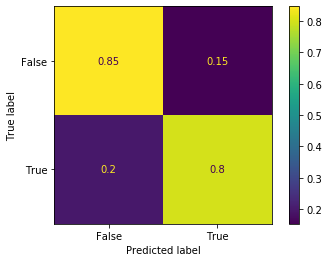

CPU times: user 7min 49s, sys: 12.9 s, total: 8min 2s
Wall time: 2min 10s


In [29]:
%%time
# adding more iterations to facilitate convergence
clf = MLPClassifier(activation='relu', alpha=0.00001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 100), learning_rate='invscaling',
              learning_rate_init=0.001, max_fun=15000, max_iter=400,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1337, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
clf_report(clf, X_train, y_train, X_test, y_test)

MLP model performed better than Random Forest Classifier. However, it was much slower to train than random forest.

## Observations
- Class and overall accuracy has been calculated using confusion matrix. However, in this context, recall also serves as accuracy.
- Cross validation scores are similar for all folds. This shows that the models are not overfitting to specific sets.
- Cross validation performance is similar to test performance, which again shows that the models generalize well.
- Normalizing the dataset distorted the signals and made the performance worse.
- Neural network classifier performed slightly better than the random forest classifier. However, RFC was much faster to train and it took only 6 seconds to complete instead of 1.5 minutes.

## Conclusion

In the original research done by [Killian, J.A., Passino, K.M., Nandi, A., Madden, D.R. and Clapp, J., Learning to Detect Heavy Drinking Episodes Using Smartphone Accelerometer Data. In Proceedings of the 4th International Workshop on Knowledge Discovery in Healthcare Data co-located with the 28th International Joint Conference on Artificial Intelligence (IJCAI 2019) (pp. 35-42)](http://ceur-ws.org/Vol-2429/paper6.pdf), the researchers used MFCC features to extract spectral information of the signals. MFCC however is modeled after human auditory response and is useful for analyzing speech signals. Whether it would be effective in analyzing accelerometer data is something that is to be verified. We could re-run the experiment and use MFCC features instead of STFT to figure this out.

Using STFT and RMS features, I was able to build models that achieved higher performance than the original study in accuracy, precision and recall. Both neural network and random forest classifier models achieved almost similar performance with neural network having a slight edge over the other. Based on implementation requirements, we can pick the appropriate classifier for the situation.

From the reports above, we can see that the models are better at predicting if a person is sober. Depending on the importance of intoxication prediction, we can tune precision/recall of "Intoxicated" class. For example, if we should be conservative and not alert the user of intoxication unless the predicition confidence is high, we can decrease the class weight of 'Intoxicated' category so that its precision score would improve.

## Future Steps
As mentioned in the introduction, due to the time limited nature of this exercise, I am including further ideas for improving the model in this section.
- Analyze which population is incorrectly classified to find clues on how to improve the model further.
- Train deep learning models on Spectrogram plots to identify underlying patterns.
- Test the effects of adding overlap using hop_length.
- Extract more features like zero_crossing_rate, frequency rolloff, etc.
- Tune the models based on the application. For example, if false positives are not dangerous, we can boost the recall of "Intoxicated" class by increasing the class weight.
- MLPClassifier does not accept class weights. Oversample the minority class to test the performance of MLPClassifier on a balanced dataset.
- Test the effects of dimensionality reduction using PCA.